# 01 Intro Homework
The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

## Contents
- [Q1. Downloading the data](#q1)
- [Q2. Computing duration](#q2)
- [Q3. Dropping outliers](#q3)
- [Q4. One-hot encoding](#q4)
- [Q5. Training a model](#q5)
- [Q6. Evaluating the model](#q6)

In [1]:
import pandas as pd
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

### Q1. Downloading the data<a id="q1"></a>
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [2]:
# Read the training set into a dataframe
df_train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

print(f'There are {len(df_train.columns)} columns in the January dataset.')

There are 19 columns in the January dataset.


#### Q2. Computing duration<a id="q2"></a>
Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [3]:
# Convert datetime columns to datetime
df_train["tpep_dropoff_datetime"] = pd.to_datetime(df_train["tpep_dropoff_datetime"])
df_train["tpep_pickup_datetime"] = pd.to_datetime(df_train["tpep_pickup_datetime"])

# Calculate the trip duration in minutes
df_train["duration"] = df_train["tpep_dropoff_datetime"] - df_train["tpep_pickup_datetime"]
df_train["duration"] = df_train["duration"].apply(lambda x: x.total_seconds() / 60)

print(f'The standard deviation of the trips during January is {df_train["duration"].std():.2f}.')

The standard deviation of the trips during January is 42.59.


### Q3. Dropping outliers<a id="q3"></a>
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [4]:
# Calculate the number of records in the raw data
raw_len = len(df_train)

# Filter out the outliers
df_train = df_train[(df_train["duration"] >= 1) & (df_train["duration"] <= 60)]

# Calculate the number of records in the filtered data
clean_len = len(df_train)

print(f'{clean_len / raw_len:.2%} of the records remain after filtering for outliers.')

98.12% of the records remain after filtering for outliers.


### Q4. One-hot encoding<a id="q4"></a>
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [5]:
# Define the categorical columns
categorical = ['PULocationID', 'DOLocationID']

# Define the target variable
target = "duration"

# Convert the categorical columns to string
df_train[categorical] = df_train[categorical].astype(str)

# One-hot encode the categorical columns
dv = DictVectorizer()
train_dicts = df_train[categorical].to_dict(orient='records')

# Initialize the target and features
X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values
features = dv.feature_names_

print(f'There are {len(features)} features after one-hot encoding.')

There are 515 features after one-hot encoding.


### Q5. Training a model<a id="q5"></a>
Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [6]:
# Train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Compute the predictions on the training set
y_pred = lr.predict(X_train)

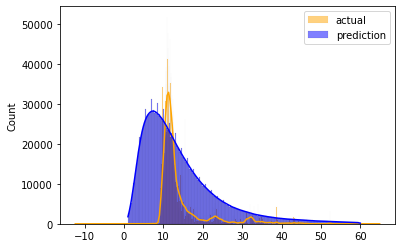

In [7]:
# Visualize the Distributions of the predictions and the true labels
sns.histplot(y_pred, label="actual", color="orange", kde=True)
sns.histplot(y_train, label="prediction", color="blue", kde=True)
plt.legend()
plt.show()

In [8]:
# Calculate the RMSE
rmse = mean_squared_error(y_train, y_pred, squared=False)

print(f'The RMSE of the model on the training set is {rmse:.2f} minutes.')

The RMSE of the model on the training set is 7.65 minutes.


### Q6. Evaluating the model<a id="q6"></a>
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [9]:
def preprocessing(file: str, target: str) -> pd.DataFrame:
    """
    Read the parquet file and preprocess it.

    Arguments:
        file (str): The name of the parquet file to be read.
        target (str): The name of the target variable.

    Returns:
        df (pd.DataFrame): The preprocessed DataFrame.
    """
    # Read the raw data
    df = pd.read_parquet(file)

    # Convert datetime columns to datetime
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])

    # Calculate the trip duration in minutes
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["duration"] = df["duration"].apply(lambda x: x.total_seconds() / 60)

    # Filter out the outliers
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    # Convert the categorical columns to string
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    # Return the target and the features
    return df[categorical + [target]]

In [10]:
# Read the test set into a dataframe
df_test = preprocessing(
    file='https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
    target=target
)

# One-hot encode the categorical columns
df_dict = df_test.to_dict(orient='records')

# Initialize the target and features 
X_test = dv.transform(df_dict)
y_test = df_test[target].values

# Compute the predictions on the training set
y_pred = lr.predict(X_test)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'The RMSE of the model on the validation set is {rmse:.2f} minutes.')

The RMSE of the model on the validation set is 7.81 minutes.
